## Problem 6.10

In this problem we will compare an explicit and implicit timescheme for the heat equation, 
$$
\partial_t \theta = \alpha \, \partial_x^2 \theta  \quad. 
$$ First let us look at the explicit scheme. 


### Explicit scheme 

Using the forward difference approximation in time and a centred finite difference for the spatial gradient temperature, $\theta$, at the next timestep $n+1$ may be approximated as 
$$
 \theta_j^{n+1} = \theta_j^n + \frac{\alpha\, \Delta t}{(\Delta x)^2} \left( \theta_{j+1}^n - 2\theta_j^n + \theta_{j-1}^n \right) 
$$


Let us first set up the domain and define a function for the initial condition: 

In [83]:
import numpy as np 
import matplotlib.pyplot as plt 


# Since the dx is 1, lets initialise x using arange
x  = np.arange(0, 101)
dx = 1 
# Initialise theta array of the same length
N = len(x)
theta = np.zeros(N)


# Set alpha value 
alpha = 1.0


#### Initial condition: 

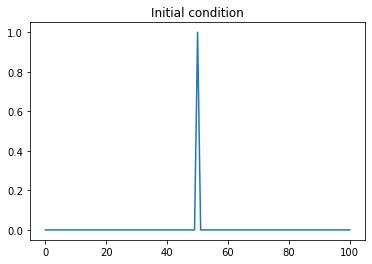

In [18]:
def set_init_condition(x, theta): 
    theta[:]     = 0
    theta[x==50] = 1
    return theta 

# Set the initial condition and plot it
theta   = set_init_condition(x, theta)


fig, ax = plt.subplots()
ax.plot(x, theta)
ax.set_title('Initial condition');

#### Timestepping: 

Below we define the function that solves for $\theta^{n+1}$ based on  $\theta^{n}$. We will impose boundary conditions that $\theta^{n} = 0 $ for $x = 0, L$.

In [16]:
def explicit_step_in_time(theta, alpha, dt, dx):
    # theta = 1D array, current timestep n
    # alpha = float, diffusivity
    # dt    = float, timestep
    # dx    = float, grid spacing
    
    # Impose boundary conditions
    theta[0]  = 0 
    theta[-1] = 0 
    
    # Update values not at boundary
    theta[1:-1] = theta[1:-1] + (alpha*dt/(dx*dx)) * (theta[2:] - 2*theta[1:-1] + theta[:-2])

    return theta 

#### Investigating the stability

We can vary the stability of this scheme by varying the value of $k$ where $\Delta t = \alpha (\Delta x)^2 / k$. It appears there is a slight typo in the question. It is supposed to be asking the reader to test how the stability changes when the timestep is between 0.4 and 0.6. We can relate these to $k$ values of 10/4 and 10/6. Below we will plot 3 figures for different timesteps of 0.4, 0.5 and 0.6. In each plot we show the initial condition in grey, and the temperature at the current timestep in blue. We observe a system that is stable ($\Delta t = 0.4$), on the edge of stability ($\Delta t = 0.5$) and completely unstable ($\Delta t = 0.6$). 

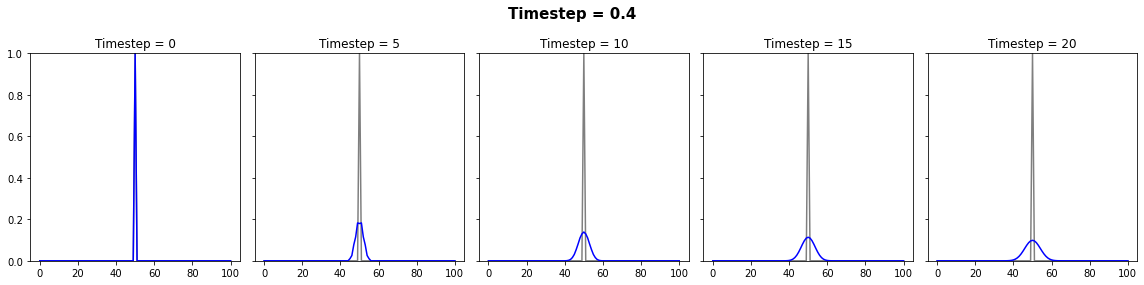

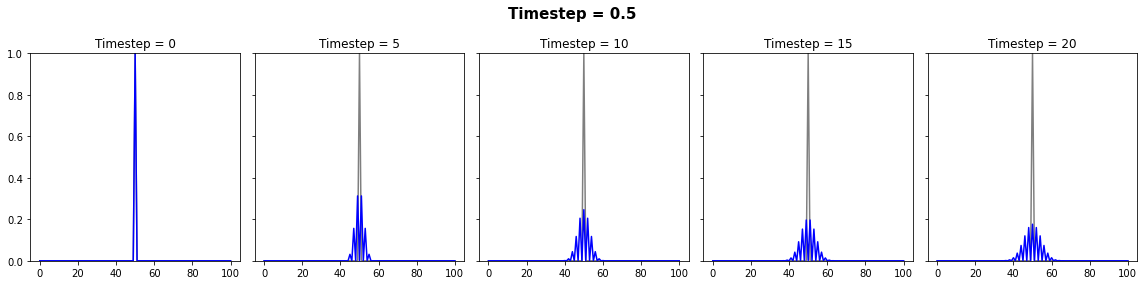

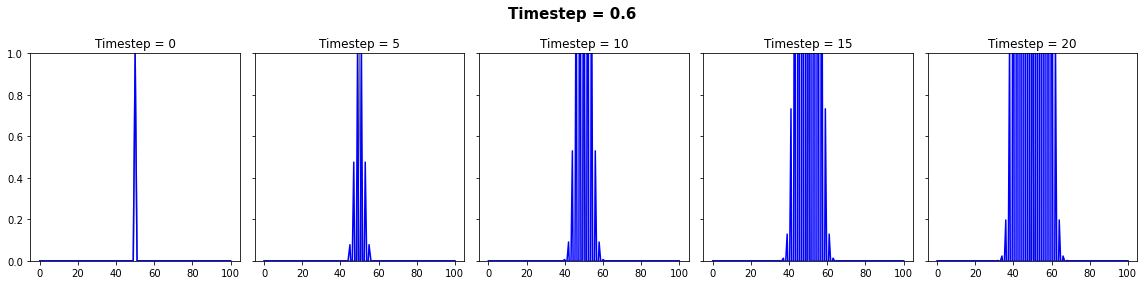

In [82]:
for k in [10/4, 10/5, 10/6]: 
    dt = alpha * (dx**2) / k


    # Lets reimpose the boundary conidition to ensure it is 
    # imposed every time we run this notebook cell 
    theta   = set_init_condition(x, theta)

    # Setup 5 subplots
    nplots = 5
    fig, ax = plt.subplots(1,nplots, figsize=(16,4), sharey=True, sharex=True)
    fig.set_tight_layout(True)
    fig.suptitle(f'Timestep = {dt}', fontsize=15, weight='bold')

    # Plot the initial condition on each of the subplots
    for j in range(nplots): 
        ax[j].plot(x, theta, 'k', alpha=0.5) 

        
        
        
    # Loop through each timestep (i) and plot every 'plot_every'th timestep so that
    # there are 5 plots 
    ntimesteps = 25 
    plot_every = int(ntimesteps/nplots)
    
    ictr = 0 
    for i in range(ntimesteps):
        
        
        if i%plot_every==0:
            ax[ictr].plot(x, theta, 'b')
            ax[ictr].set_title(f'Timestep = {i}')
            ax[ictr].set_ylim([0,1])
            ictr += 1

        theta = explicit_step_in_time(theta, alpha, dt, dx)

### Implicit scheme 

Using the forward difference approximation in time and a centred finite difference for the spatial gradient temperature, $\theta$, at the next timestep $n+1$ may be approximated as 

$$
- \beta\, \theta^n_{j-1} + \gamma \,\theta_j^n  - \beta \, \theta^n_{j+1} = \theta^{n-1}_j
$$

where I am denoting $\beta = \frac{\alpha \, \Delta t}{(\Delta x)^2}$ and $\gamma = \left[ 1 + 2 \beta\, \right]$. This system of linear equations for each spatial point, $j= 1, N$ may then be written as a matrix: 

$$
\begin{bmatrix} 
1 &  &  &  & &  &  \\
-\beta & \gamma & -\beta &  &  &  &   \\ 
 & -\beta & \gamma & -\beta &  &  &   \\ 
      &  &   \ddots & \ddots & \ddots & & \\
 &  & &  -\beta & \gamma & -\beta &   \\ 
 &  &  &  & -\beta & \gamma & -\beta \\ 
 &  &  &  &  &  & 1 
\end{bmatrix} \begin{bmatrix} \theta_0^n \\ \theta_1^n \\ \theta_2^n  \\ \vdots \\ \theta_{N-2}^n \\ \theta_{N-1}^n \\ \theta_{N}^n \end{bmatrix} = 
\begin{bmatrix} \theta_0^{n-1} \\ \theta_1^{n-1} \\ \theta_2^{n-1} \\ \vdots  \\ \theta_{N-2}^{n-1} \\ \theta_{N-1}^{n-1} \\ \theta_{N}^{n-1} \end{bmatrix} \quad, 
$$
or in matrix form as 
$$
    \mathbf{K} \mathbf{\Theta}^{n}  =  \mathbf{\Theta}^{n-1} .
$$

The structure of the matrix $\mathbf{K}$ is sparse (mostly zeros) and tri-diagonal. Note that the values in the first and last rows ensure that 
$$
\theta^n_0 = \theta^{n-1}_0 \\ 
\theta^n_N = \theta^{n-1}_N \\ 
$$
as per the Dirichlet boundary condition. As long as $\mathbf{K}$ can be inverted, this solution may then be time-marched as 

or in matrix form as 
$$
    \mathbf{\Theta}^{n}  = \mathbf{K}^{-1}  \mathbf{\Theta}^{n-1} ,
$$ and since $\mathbf{K}$ is time-independent, the inversion must be completed only once. In the code cell below, a function is written to build the $\mathbf{K}$ matrix. Plotting this matrix, we then see the tridiagonal structure.

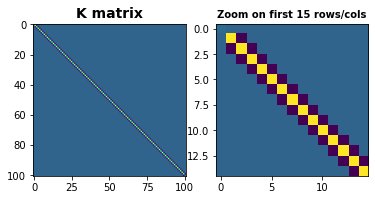

In [106]:
def build_K_mat(alpha, dt, dx):

    beta =  alpha*dt/(dx**2)
    gamma = 1 + 2*beta

    # Build our matrix 
    K = np.zeros((N,N))

    # Avoiding the first and last elements: 
    for i in range(1, N-1): 
        K[i,i] = gamma
        K[i+1,i] = -beta
        K[i,i+1] = -beta
    K[0,0]   = 1
    K[-1,-1] = 1
    return K

K = build_K_mat(alpha, dt, dx)
    

fig, ax = plt.subplots(1,2) 
ax[0].set_title('K matrix', weight='bold', fontsize=14)
ax[0].imshow(K);

n = 15
ax[1].imshow(K[:n, :n]);
ax[1].set_title(f'Zoom on first {n} rows/cols', weight='bold', fontsize=10);


#### Solving with the Implicit method

The code snippet below is identical to the code above apart from the following 
- It computes K for the chosen timestep and inverts it
- The ```explicit_step_in_time``` is replaced with a line of code that simply computes the matrix calculation $\mathbf{\Theta}^{n}  = \mathbf{K}^{-1}  \mathbf{\Theta}^{n-1} $ 

In this case we will try the same timesteps as above, as well as $\Delta t = 10$. Since this setup is unconditionally stable, all these timesteps provide a stable solution.

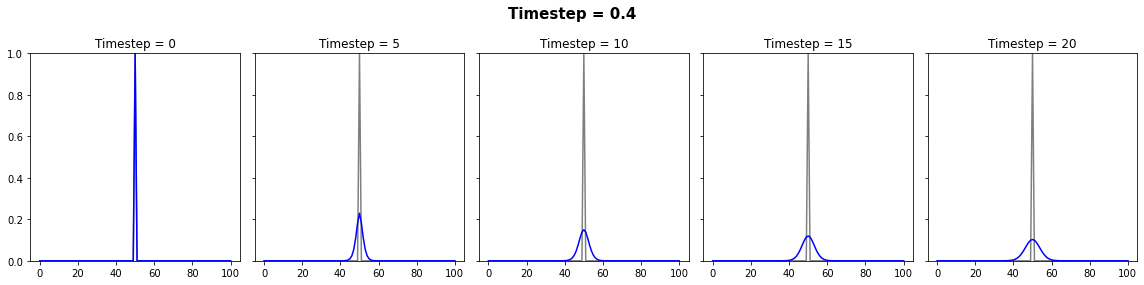

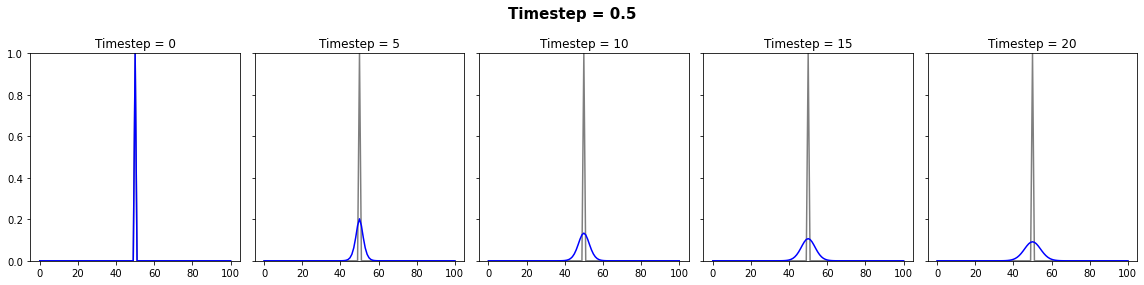

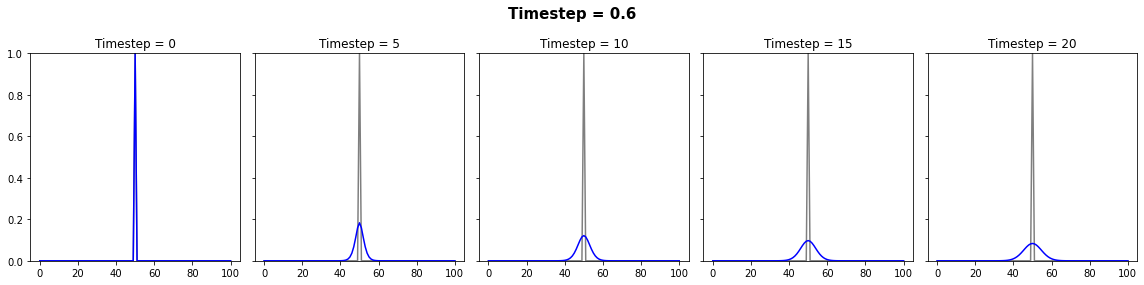

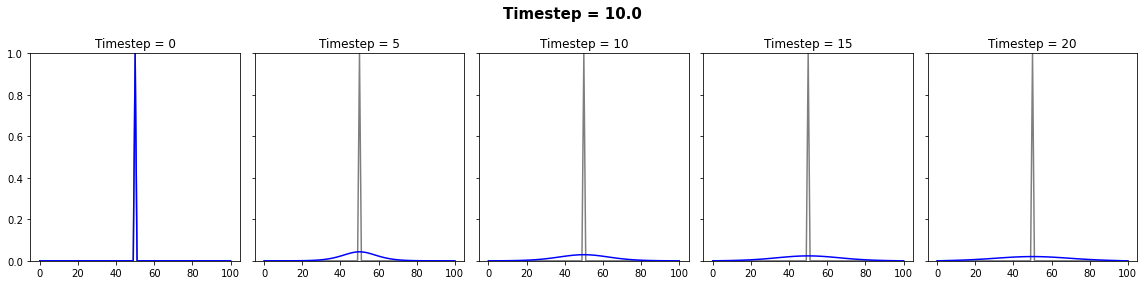

In [105]:
for k in [10/4, 10/5, 10/6, 0.1]: 
    dt = alpha * (dx**2) / k

    # Compute the K matrix for this timestep: 
    K = build_K_mat(alpha, dt, dx)
    Kinv = np.linalg.inv(K)

    # Lets reimpose the boundary conidition to ensure it is 
    # imposed every time we run this notebook cell 
    theta   = set_init_condition(x, theta)

    # Setup 5 subplots
    nplots = 5
    fig, ax = plt.subplots(1,nplots, figsize=(16,4), sharey=True, sharex=True)
    fig.set_tight_layout(True)
    fig.suptitle(f'Timestep = {dt}', fontsize=15, weight='bold')

    # Plot the initial condition on each of the subplots
    for j in range(nplots): 
        ax[j].plot(x, theta, 'k', alpha=0.5) 
        
        
    # Loop through each timestep (i) and plot every 'plot_every'th timestep so that
    # there are 5 plots 
    ntimesteps = 25 
    plot_every = int(ntimesteps/nplots)
    
    ictr = 0 
    for i in range(ntimesteps):
        
        
        if i%plot_every==0:
            ax[ictr].plot(x, theta, 'b')
            ax[ictr].set_title(f'Timestep = {i}')
            ax[ictr].set_ylim([0,1])
            ictr += 1

        theta = np.matmul(Kinv, theta)
    